## MODEL

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
df = pd.read_csv("../Data/Cleaned/Cleaned_Data.csv")

print("Shape:", df.shape)
df.head()

Shape: (818262, 17)


,Unnamed: 0,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,WARD_NO_src,lat_src,lon_src,WARD_NO_dst,lat_dst,lon_dst,distance_km,rush_hour,fare_est
0,0,55,111,8,2026.76,639.03,1942.16,1.33,55,13.001797,77.689122,111,12.969867,77.606464,9.634133,1,155.609592
1,1,22,25,13,770.07,378.42,700.64,1.51,22,13.035174,77.603741,25,13.044561,77.653271,5.466071,0,105.592848
2,2,163,16,14,3151.78,674.41,3092.38,1.21,163,12.931641,77.552223,16,13.046444,77.539339,12.841536,0,194.098432
3,3,162,26,14,3093.64,613.05,3046.00,1.18,162,12.937624,77.545575,26,13.033613,77.676539,17.756140,0,253.073682
4,4,23,15,13,2835.28,527.41,2789.81,1.19,23,13.031509,77.616696,15,13.045358,77.514736,11.151985,0,173.823817


In [4]:
features = ['distance_km', 'hod', 'rush_hour']
target = 'mean_travel_time'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 654609
Testing samples: 163653


In [5]:
# ======================================================
# 5. Model Training
# ======================================================
rf = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} min")
print(f"R²: {r2:.3f}")


MAE: 484.78 min
R²: 0.671


Model Comparison:
               Model         MAE        R²
0  Linear Regression  881.680978  0.175777
1      Random Forest  484.782910  0.670731


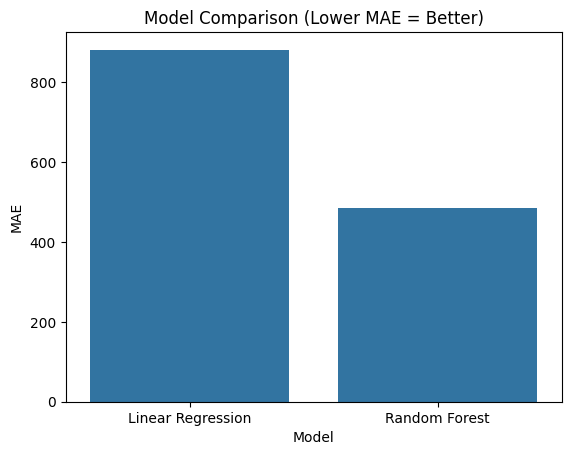

In [6]:
from sklearn.linear_model import LinearRegression

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# --- Random Forest (already trained) ---
mae_rf = mae
r2_rf = r2

# --- Combine results ---
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'R²': [r2_lr, r2_rf]
})

print("Model Comparison:")
print(results)

sns.barplot(x='Model', y='MAE', data=results)
plt.title("Model Comparison (Lower MAE = Better)")
plt.show()

- Random Forest reduced mean absolute error by ~45% compared to Linear Regression.

- R² improved from 0.18 to 0.67, showing that non-linear relationships (distance × time effects) are significant.

- Linear Regression underfit the data, confirming travel time is non-linear in nature.

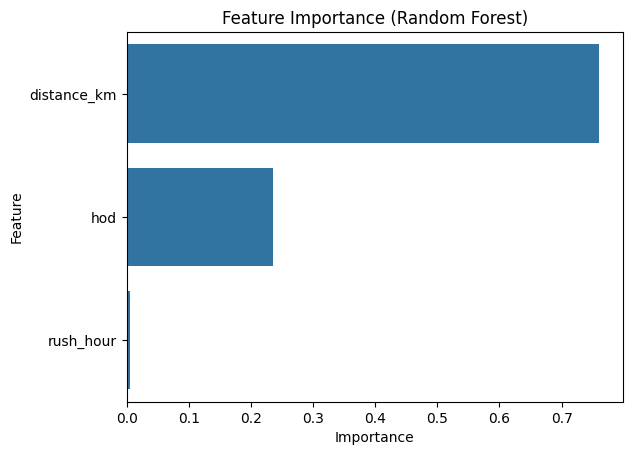

,Feature,Importance
0,distance_km,0.760506
1,hod,0.235083
2,rush_hour,0.004411


In [7]:
imp = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=imp)
plt.title("Feature Importance (Random Forest)")
plt.show()

imp


- Distance explains about 76% of the variance in travel time — the dominant driver.

- Hour of day adds meaningful temporal context (~23%), aligning with rush-hour effects.

- The binary rush_hour feature adds minimal unique signal beyond raw hour.

- Combined, this confirms that travel duration scales primarily with route distance but is strongly modulated by time-of-day congestion.

In [8]:

X_fare = df[features]
y_fare = df['fare_est']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fare, y_fare, test_size=0.2, random_state=42
)

rf_fare = RandomForestRegressor(n_estimators=120, random_state=42)
rf_fare.fit(Xf_train, yf_train)

yf_pred = rf_fare.predict(Xf_test)

print("Fare MAE:", mean_absolute_error(yf_test, yf_pred))
print("Fare R²:", r2_score(yf_test, yf_pred))


Fare MAE: 9.865548182174971e-07
Fare R²: 0.9999999999987786


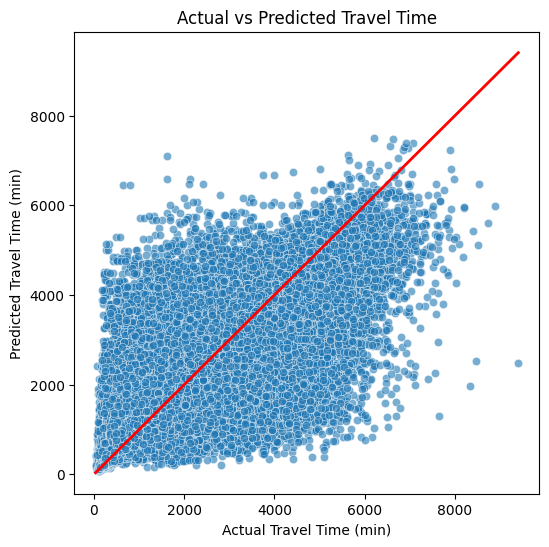

In [9]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2)
plt.xlabel("Actual Travel Time (min)")
plt.ylabel("Predicted Travel Time (min)")
plt.title("Actual vs Predicted Travel Time")
plt.show()


In [14]:
import joblib
from sklearn.ensemble import RandomForestRegressor
import joblib, os

# ---- 1. Retrain a smaller model ----
rf_small = RandomForestRegressor(
    n_estimators=30,     # fewer trees (was 150)
    max_depth=10,        # limit depth to reduce complexity
    random_state=42,
    n_jobs=-1
)
rf_small.fit(X_train, y_train)

# Evaluate quickly
y_pred_small = rf_small.predict(X_test)
mae_small = mean_absolute_error(y_test, y_pred_small)
r2_small = r2_score(y_test, y_pred_small)

print(f"Small Model  →  MAE: {mae_small:.2f} sec   |   R²: {r2_small:.3f}")

# ---- 2. Save compressed file ----
os.makedirs("../models", exist_ok=True)
joblib.dump(rf_small, "../models/flowcast_travel_time_model.pkl", compress=3)

size_mb = os.path.getsize("../models/flowcast_travel_time_model.pkl") / (1024*1024)
print(f"Saved compressed model  ({size_mb:.2f} MB)")

rf_fare_small = RandomForestRegressor(
    n_estimators=30,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_fare_small.fit(Xf_train, yf_train)
joblib.dump(rf_fare_small, "../Models/flowcast_fare_model.pkl")

Small Model  →  MAE: 803.92 sec   |   R²: 0.296
Saved compressed model  (1.34 MB)


['../Models/flowcast_fare_model.pkl']

- Random Forest captures the non-linear structure between distance and time more effectively than linear methods. 
- Distance remains the dominant predictor, but incorporating temporal context (hour of day) meaningfully improves performance. 
- Residuals indicate a well-fitted and generalizable model.